In [2]:
# Allow display of images
from IPython.display import display, Image

# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
import glob

import pandas as pd
import seaborn as sns
from scipy import fftpack
import scipy as sp

# Tools from brainsignal library
import os
import sys
path=r'C:\Users\Hamon\Documents\Stage\brainsignal'
sys.path.append(path)
import brainsignal.datageneration as dg
import brainsignal.datanalysis as da
import brainsignal.HRVanalysis as ha
import brainsignal.bodediagram as bd

# This makes the plots appear inside the notebook
%matplotlib inline

#### Chirp sinusoidal function

In [3]:
import math

def chirp(N,fs, r = 0.05, w1=0, w2=np.pi):
  # Dan Boschen 4/18/2020

  n= np.arange(0,N)                       # sample index
  n1 = math.ceil(r*N/4)               # start ramp at 50% in window rise 
  n2 = N-n1-1                 # end ramp at 50% in window fall
    
  spantime = n/fs 

  # phase versus time for linear ramp 
  w = w1*n + (w2-w1)/(n2-n1)*(n-n1)

  # constant frequency outside of Tukey window
  w[0:n1] = w1*np.ones(n1)
  w[n2::] = w2*np.ones(N-n2)

  a = sp.signal.tukey(N,r)       # Tukey Window
  
  return a*np.sin(w*spantime), a, w/(2*np.pi)   



In [4]:
N = 2**16         # number of samples
fs = 60             # sampling rate 
n =np.arange(0,N)            # sample index
spantime = n/fs          # time index

signal,a,f=chirp(N,fs, r = 0.05, w1=0, w2=2*np.pi)

plt.figure()
plt.plot(spantime,f)

plt.figure()
plt.plot(spantime,a)

plt.figure()
plt.plot(spantime,signal)

#### Blood pulse with variables parameters

[  0  60 120 180 300]


Text(0, 0.5, 'amplitude')

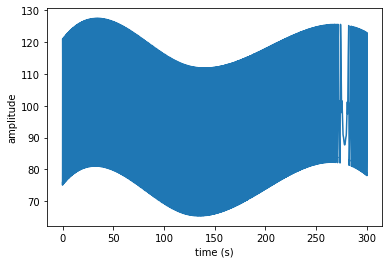

In [5]:
# Blood paramters variation from data points
# time points 
duration=60*5 #s
rate=200 # Hz
fs=rate
spantime=dg.generate_time(duration,rate)

# datapoints
datatimes=np.array([0,1,2,3,5])*60 # sec #todo : try without np.array() and print the variable : what happens ?
print(datatimes)
dataPsys=np.array([121,125,113,115,123])
dataPdia=np.array([75,78,66,70,78])
dataHB=np.array([79,75,63,75,77])/60  # Hz

# fit a smooth function to the data
from scipy.interpolate import InterpolatedUnivariateSpline
##Psys interpolation
Psys=InterpolatedUnivariateSpline(datatimes,dataPsys)

##Pdia interpolation 
Pdia=InterpolatedUnivariateSpline(datatimes,dataPdia)

##HB interpolation 
HB=InterpolatedUnivariateSpline(datatimes, dataHB)

# generate a blood pressure signal with the fitted varying paramters
signal=dg.generate_ABP(spantime,Psys(spantime),Pdia(spantime),HB(spantime))
plt.figure()
plt.plot(spantime,signal)
plt.xlabel('time (s)')
plt.ylabel('amplitude')

This sinus will be our input signal.

## Transfer function choice

Let consider a second order system with natral frequency $w_n=2 \pi 3$, a damping ratio $\xi=2$ and a gain $K=2$

$$G=\frac{K}{s^2+2 \xi w_n s + w_n^2}$$

In [6]:
K=1000
xi=0.1
wn=2*np.pi*3

In [7]:
num=[0,0,K]
den=[1,2*xi*wn,wn**2]

In [8]:
# get frequency vector 
fth=bd.find_freq_vect(spantime)
# pulsation initialization 
w=2*np.pi*fth


# transfer function
s=1.0j*w
#Hjw=(s**2+0.2*s+0.3)/(s**2+2*s+0.1)
Hjw=(num[0]*s**2+num[1]*s+num[2])/(den[0]*s**2+den[1]*s+den[2])

#### Bode diagram

##### Bode diagram with our function 

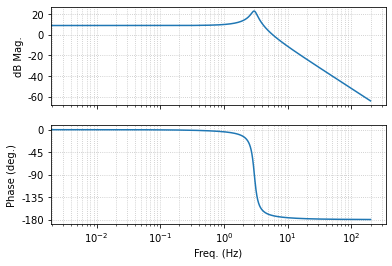

In [9]:
dB_magth ,phaseth = bd.find_dB_mag_and_phase(Hjw)
magth=np.abs(Hjw)

#Bode plot 
bd.bode_plot(fth, dB_magth, phaseth)

##### Bode diagram with scipy function 

/home/alexandra/anaconda3/envs/IA/lib/python3.8/site-packages/scipy/signal/filter_design.py:1630: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


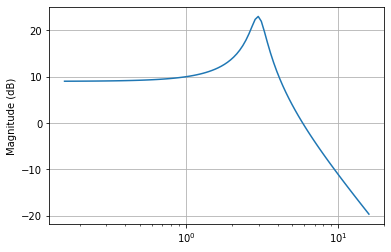

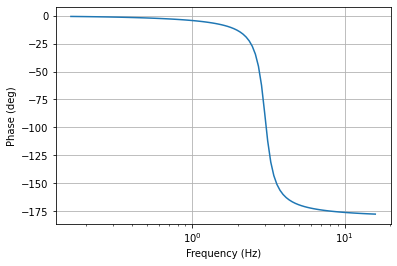

In [10]:
sys=sp.signal.TransferFunction(num,den)
w, magscipy, phasescipy=sp.signal.bode(sys)

fscipy=w/(2*np.pi)

#Bode plot 
plt.figure()
plt.semilogx(fscipy, magscipy) # Bode magnitude plot
plt.ylabel('Magnitude (dB)')

plt.grid()
plt.figure()
plt.semilogx(fscipy, phasescipy)  # Bode phase plot
plt.ylabel('Phase (deg)')
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.show()

### The Nyquist plot

The Nyquist plot combines gain and phase into one plot in the complex plane. It is drawn by plotting the complex gain $G(\omega)$ for all frequencies $\omega$.

In [11]:
w = np.linspace(0, 2*np.pi, 100)
# transfer function
s=1.0j*w
Hjw=(num[0]*s**2+num[1]*s+num[2])/(den[0]*s**2+den[1]*s+den[2])

r = np.sqrt(1.0)
c1 = r*np.cos(theta)
c2 = r*np.sin(theta)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
plt.plot(c1,c2,'gray')
plt.plot(np.real(Hjw),np.imag(Hjw))
plt.plot(np.real(Hjw),-np.imag(Hjw),'--')
plt.xlabel(r'$Z\'(\omega)$')
plt.ylabel(r'$Z\"(\omega)$')
plt.grid(True)
Xmax=np.max([abs(np.real(Hjw)).max(),abs(np.imag(Hjw)).max()])
plt.xlim([-Xmax,Xmax])
plt.ylim([-Xmax,Xmax])
plt.grid(linestyle='--')

NameError: name 'theta' is not defined

#### Output 

We know that Y(s)=H(s).X(s)

In [ ]:
# calculation of discrete fourier transform of the input signal 
X=fftpack.fft(signal)
# The corresponding frequencies
sample_freq = fftpack.fftfreq(signal.size, d=spantime[1]-spantime[0])
# pulsation 
w=2*np.pi*sample_freq
# 
s=1.0j*w
# transfer function
Hjw=(num[0]*s**2+num[1]*s+num[2])/(den[0]*s**2+den[1]*s+den[2])

# multiplication 
Y=Hjw*X

# inverse FFT 
outputFFT=np.real(fftpack.ifft(Y))

Option 2 : We simulate the output using the signal lsim function

In [ ]:
#sys=sp.signal.TransferFunction(num,den)
sys=sp.signal.lti(num,den)
tout, output, xout = sp.signal.lsim(sys, U=signal, T=spantime)

In [ ]:
plt.plot(spantime,signal, label='x(t)')
plt.plot(spantime,outputFFT, label='y(t)')
plt.plot(spantime,output, label='y(t)')
plt.plot(spantime[0::],output[0::], label='y(t)')

## Periodogram of the signals

In [ ]:
# limitation in the freqency domain analysis

In [ ]:
lowf=0.01 #Hz
highf=10 #Hz

In [ ]:
plt.figure()
freq,power=da.periodogram(signal,spantime)

## look for the main frequency 
f0,indf=da.searchpeak(signal,freq,fmin=0.2,fmax=2)
print('Heart frequency (Hz)=',f0)
print('Peak indice=',indf)

# filter the frequncy range of interest
filter=(freq>=lowf)&(freq<=highf)
indices=np.where(filter)[0]

plt.plot(freq[indices],power[indices])
plt.plot(freq[indf],power[indf],'r*')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Periodogram')


plt.figure()
freq,power=da.periodogram(output-np.mean(output),spantime, window=sp.signal.windows.hamming)
da.plot_periodogram(freq[indices],power[indices])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Periodogram')

### Transfer function from harmonics

In [ ]:
def dft(x,f0,fs):
    """Compute the Discrete Fourier Transform of the 1d ndarray x for the frequency f0"""
    N = x.size
    n = np.arange(N)
    k = n.reshape((N, 1))
    k0=f0/fs*N  
    # complex number in python are denoted by the j symbol,
    # instead of i that we're showing in the formula
    e = np.exp(-2j * np.pi * k0 * n / N)
    return np.dot(e, x)

In [ ]:
window=sp.signal.windows.hann

## Selection de fréquences
spanFreqs=np.arange(1,8+1)*f0


## Calcul de la fonction de tranfer pour chaque fréquence
G_harmonics=[]
for fi in spanFreqs :
    G_harmonics.append(dft(output*window(len(signal)),fi,fs)/dft(signal*window(len(signal)),fi,fs))

## Calcul du grain et du déphasage pour chaque fréquence
Amp_harmonics=np.abs(G_harmonics)
Phase_harmonics=np.arctan2(np.imag(G_harmonics),np.real(G_harmonics))

In [ ]:
## Comparaison avec le grain et le déphasage théorique

#Bode plot 
plt.figure()
plt.semilogx(fscipy, magscipy) # Bode magnitude plot
plt.semilogx(spanFreqs,20*np.log10(Amp_harmonics),'*')

plt.ylabel('Magnitude (dB)')
plt.xlabel('frequency(Hz)')
plt.grid()

plt.figure()
plt.semilogx(fscipy, phasescipy)  # Bode phase plot
plt.semilogx(spanFreqs,Phase_harmonics*180/np.pi,'*')  # Bode phase plot

plt.ylabel('Phase (deg)')
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.show()


### Transfer function from cross power spectral density

Method using the cross power spectral density, Pxy, using Welch’s method

In [ ]:
## Look how the nperseg changes the results : 
# with nperseg=256, the results is not good enought
# try to explain that. what is the Welch method ?

f_Pyx, Pyx =sp.signal.csd(signal,output, fs=fs, window='hann',nperseg=1024)
f_Pxx, Pxx =sp.signal.csd(signal, signal, fs=fs, window='hann',nperseg=1024)

# remove the 0 freq
f_Pyx=f_Pyx[1::]
Pyx=Pyx[1::]
Pxx=Pxx[1::]

TFPyx=Pyx/Pxx

dB_mag_Pyx ,phase_Pyx = bd.find_dB_mag_and_phase(TFPyx)

### Transfer function from FFT + window

In [ ]:
# fft 
window=sp.signal.windows.flattop 
window=sp.signal.windows.hann
#window=np.hanning

#input 
X=fftpack.fft(signal*window(len(signal))) 

#output 
Y=fftpack.fft(output*window(len(signal)))

#transfer function 
H=Y/X

# The corresponding frequencies
sample_freq = fftpack.fftfreq(signal[0::].size, d=spantime[1]-spantime[0])

dB_mag ,phase = bd.find_dB_mag_and_phase(H)

### Transfer function from ARMA method

Essayer avec ARMAX ici pour comparer ?

## Comparison of methods on Bode diagram

In [ ]:
import math
sample_freq
N=len(sample_freq)
Nlim=math.floor(N/2)

You can see that our TF estimates doesnt work well for high frequency because the input signal doesnt have much high frequencies. so the system is not tested in the high frequency regime.

I think we should keep this in mind and look caarefully the the input and output spectrum before doing the TF estimate.

In [ ]:
lowf=0.01
highf=15

#Gain 
plt.figure()

plt.plot(sample_freq[0:Nlim], dB_mag[0:Nlim], '-',linewidth=4, label='transfer function FFT')
plt.plot(f_Pyx, dB_mag_Pyx, '-',linewidth=3, label='transfer function Pyx')
plt.plot(spanFreqs,20*np.log10(Amp_harmonics),'^',markersize=10, label='evaluation on harmonics')


plt.plot(fth, dB_magth,'k--',linewidth=2,label='transfer function original')

plt.xlabel('Freq. (Hz)')
plt.ylabel('dB Mag.')

plt.xlim([lowf,highf])

#plt.xscale('log')
plt.grid()
plt.legend()

#Phase
plt.figure()
plt.plot(sample_freq[0:Nlim], phase[0:Nlim], '-',linewidth=4,label='transfer function FFT')
plt.plot(f_Pyx, phase_Pyx, '-',linewidth=3,label='transfer function Pyx')
plt.plot(spanFreqs,Phase_harmonics*180/np.pi,'^',markersize=10, label='evaluation on harmonics')
plt.plot(fth, phaseth,'k--',linewidth=2, label='transfer function original')


plt.xlim([lowf,highf])
#plt.xscale('log')
plt.ylim([-180,0])
plt.ylabel('Phase (deg.)')
plt.xlabel('Freq. (Hz)')
plt.grid()
plt.legend()

## Fit of a function

Let try to recover the coefficient in the definition of the transfer function

### Data

In [ ]:
freqdata=spanFreqs
Gdata=G_harmonics
ampdata=Amp_harmonics
phasedata=Phase_harmonics

## Test with curve fit

In [ ]:
def secondorderTF(spanfreqs,a0,a1,a2,b0,b1,b2):

    # pulsation initialization 
    w=2*np.pi*spanfreqs

    # transfer function
    s=1.0j*w
    
    G=(a2*s**2+a1*s+a0)/(b2*s**2+b1*s+b0)

    return G

In [ ]:
def gain(spanfreqs,a0,a1,a2,b0,b1,b2):
    G= secondorderTF(spanfreqs,a0,a1,a2,b0,b1,b2)
    return np.abs(G)

In [ ]:
def fitfunction(spanfreqs,a0,a1,a2,b0,b1,b2):
    return gain(spanfreqs,a0,a1,a2,b0,b1,b2)

In [ ]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(fitfunction, freqdata, ampdata, p0=(0.2, 0.3, 0.5, -2.0, 4.0,7))

print('numerator :',num)
print('fitted numerator :',[popt[2],popt[1],popt[0]])

print('denominator :',den)
print('fitted denominator :',[popt[5],popt[4],popt[3]])

plt.plot(fth, magth, label='original')
plt.xlim([lowf,highf])
plt.plot(freqdata, ampdata, '.', label='data')
plt.plot( np.linspace(lowf,highf,100), gain(np.linspace(lowf,highf,100), *popt), label='fit')

plt.legend()

We have a good approximate of the Grain data but we can see that the coefficients do not correspond to the imposed transfer function. This is because we didnt take into account the phase.

Let look to the bode plot using the fitted parameters

In [ ]:
sys=sp.signal.TransferFunction([popt[2],popt[1],popt[0]],[popt[5],popt[4],popt[3]])
w, magscipy, phasescipy=sp.signal.bode(sys)

fscipy=w/(2*np.pi)

#Bode plot 
plt.figure()
plt.semilogx(fscipy, magscipy) # Bode magnitude plot
plt.ylabel('Magnitude (dB)')

plt.grid()
plt.figure()
plt.semilogx(fscipy, phasescipy)  # Bode phase plot
plt.ylabel('Phase (deg)')
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.show()

 We can see that the phase tottally disagree with the initia Bode plot

In [ ]:
sys=sp.signal.TransferFunction(num,den)
w, magscipy, phasescipy=sp.signal.bode(sys)

fscipy=w/(2*np.pi)

#Bode plot 
plt.figure()
plt.semilogx(fscipy, magscipy) # Bode magnitude plot
plt.ylabel('Magnitude (dB)')

plt.grid()
plt.figure()
plt.semilogx(fscipy, phasescipy)  # Bode phase plot
plt.ylabel('Phase (deg)')
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.show()

Lets try to combine gain and phase in one vector

In [ ]:
gainphasedata=np.append(ampdata,phasedata)
doublefreq=np.append(freqdata,freqdata)

In [ ]:
def gainphase(doublefreq,a0,a1,a2,b0,b1,b2):
    N=int(len(doublefreq)/2)
    spanfreqs=doublefreq[0:N]
    G= secondorderTF(spanfreqs,a0,a1,a2,b0,b1,b2)
    return np.append(np.abs(G),np.arctan2(np.imag(G),np.real(G)))

In [ ]:
def fitfunction(spanfreqs,a0,a1,a2,b0,b1,b2):
    return gainphase(spanfreqs,a0,a1,a2,b0,b1,b2)

In [ ]:
popt, pcov = curve_fit(fitfunction, doublefreq, gainphasedata, p0=(0.2, 0.3, 0.5, -2.0, 4.0,7))

print('numerator :',num)
print('fitted numerator :',[popt[2],popt[1],popt[0]])

print('denominator :',den)
print('fitted denominator :',[popt[5],popt[4],popt[3]])

plt.plot(fth, magth, label='original')
plt.xlim([lowf,highf])
plt.plot(freqdata, ampdata, '.', label='data')
plt.plot( np.linspace(lowf,highf,100), gain(np.linspace(lowf,highf,100), *popt), label='fit')

plt.legend()

In [ ]:
sys=sp.signal.TransferFunction([popt[2],popt[1],popt[0]],[popt[5],popt[4],popt[3]])
w, magfit, phasefit=sp.signal.bode(sys)
ffit=w/(2*np.pi)

sys=sp.signal.TransferFunction(num,den)
w, magscipy, phasescipy=sp.signal.bode(sys)
fscipy=w/(2*np.pi)

#Bode plot 
plt.figure()
plt.semilogx(ffit, magfit) # Bode magnitude plot
plt.semilogx(fscipy, magscipy) # Bode magnitude plot

plt.ylabel('Magnitude (dB)')

plt.grid()
plt.figure()

plt.semilogx(ffit, phasefit)  # Bode phase plot
plt.semilogx(fscipy, phasescipy)  # Bode phase plot
plt.ylabel('Phase (deg)')
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.show()

We have a good fit og both amplitude and phase. However the coefficient are not the one expected because we do not cover the whole frequency range to constrain the parameter estimation. 
We need to impose the number of pole and zeros !

In [ ]:
def fitfunction(doublefreq,a0,b0,b1):
    return gainphase(doublefreq,a0,0,0,b0,b1,1)

In [ ]:
popt, pcov = curve_fit(fitfunction, doublefreq, gainphasedata, p0=(0.2, -2.0, 4.0))

print('numerator :',num)
print('fitted numerator :',[popt[0]])

print('denominator :',den)
print('fitted denominator :',[1,popt[2],popt[1]])

plt.plot(fth, magth, label='original')
plt.xlim([lowf,highf])
plt.plot(freqdata, ampdata, '.', label='data')
plt.plot( np.linspace(lowf,highf,100), gain(np.linspace(lowf,highf,100), popt[0],0,0,popt[1],popt[2],1), label='fit')

plt.legend()

In [ ]:
sys=sp.signal.TransferFunction([0,0,popt[0]],[1,popt[2],popt[1]])
w, magfit, phasefit=sp.signal.bode(sys)
ffit=w/(2*np.pi)

sys=sp.signal.TransferFunction(num,den)
w, magscipy, phasescipy=sp.signal.bode(sys)
fscipy=w/(2*np.pi)

#Bode plot 
plt.figure()
plt.semilogx(ffit, magfit) # Bode magnitude plot
plt.semilogx(fscipy, magscipy) # Bode magnitude plot

plt.ylabel('Magnitude (dB)')

plt.grid()
plt.figure()

plt.semilogx(ffit, phasefit)  # Bode phase plot
plt.semilogx(fscipy, phasescipy)  # Bode phase plot
plt.ylabel('Phase (deg)')
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.show()

### Conclusion : 

We must carefully provide a form for the TF. 
Maybe we should look to the litterature if they already profided suitable TF form (ABP --> ICP)

Maybe this indicate that fitting a TF in the frequency domain is not the good way to work. 

Alternatives :
- Look to the ARMAX method
- Consider other ways to describe the TF  (we need to look first to other patients)

## Our data

In [ ]:
rep='/home/alexandra/Documents/Python/brainsignal/data/'
patientdir='ID_5'

file=glob.glob(rep+patientdir+'/WAVE_ABP.txt', recursive=True)[0]

data=pd.read_csv(file,header=None, decimal=',', delimiter='\n')
data_array=np.array(data.values)
ABP_signal=data_array.transpose()[0]

fs=200
ABP_time=np.arange(len(ABP_signal))/fs

In [ ]:
file=glob.glob(rep+patientdir+'/WAVE_ICP.txt', recursive=True)[0]

data=pd.read_csv(file,header=None, decimal=',', delimiter='\n')
data_array=np.array(data.values)
ICP_signal=data_array.transpose()[0]

fs=200
ICP_time=np.arange(len(ICP_signal))/fs

In [ ]:
# 5 seconds time scale
time=10 #beginning of the visualisation window in hour
indices=np.where((ICP_time>=time*60*60)&(ICP_time<=time*60*60+5))[0]


plt.plot(ABP_time[indices],ABP_signal[indices])
plt.plot(ICP_time[indices],ICP_signal[indices])

plt.title('Comparison radial ABP and ICP data')
plt.ylabel('mmHg')
plt.xlabel('time(h)')


In [ ]:
indices=np.where((ICP_time>=time*60*60)&(ICP_time<=time*60*60+1*60))[0]
signal=ABP_signal[indices]
output=ICP_signal[indices]
spantime=ICP_time[indices]

## Periodogram of the signals

In [ ]:
# limitation in the freqency domain analysis

In [ ]:
lowf=0.01 #Hz
highf=20 #Hz

In [ ]:
plt.figure()
freq,power=da.periodogram(signal,spantime)

## look for the main frequency 
f0,indf=da.searchpeak(signal,freq,fmin=0.7,fmax=3)
print('Heart frequency (Hz)=',f0)
print('Peak indice=',indf)

# filter the frequncy range of interest
filter=(freq>=lowf)&(freq<=highf)
indices=np.where(filter)[0]

plt.plot(freq[indices],power[indices])
plt.plot(freq[indf],power[indf],'r*')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Periodogram')
#plt.yscale('log')


plt.figure()
freq,power=da.periodogram(output,spantime, window=sp.signal.windows.hamming)
da.plot_periodogram(freq[indices],power[indices])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Periodogram')
plt.yscale('log')


### Transfer function from harmonics

In [ ]:
def dft(x,f0,fs):
    """Compute the Discrete Fourier Transform of the 1d ndarray x for the frequency f0"""
    N = x.size
    n = np.arange(N)
    k = n.reshape((N, 1))
    k0=f0/fs*N  
    # complex number in python are denoted by the j symbol,
    # instead of i that we're showing in the formula
    e = np.exp(-2j * np.pi * k0 * n / N)
    return np.dot(e, x)

In [ ]:
window=sp.signal.windows.hann

## Selection de fréquences
spanFreqs=np.arange(1,8+1)*f0


## Calcul de la fonction de tranfer pour chaque fréquence
G_harmonics=[]
for fi in spanFreqs :
    G_harmonics.append(dft(output*window(len(signal)),fi,fs)/dft(signal*window(len(signal)),fi,fs))

## Calcul du grain et du déphasage pour chaque fréquence
Amp_harmonics=np.abs(G_harmonics)
Phase_harmonics=np.arctan2(np.imag(G_harmonics),np.real(G_harmonics))

### Transfer function from cross power spectral density

Method using the cross power spectral density, Pxy, using Welch’s method

In [ ]:
## Look how the nperseg changes the results : 
# with nperseg=256, the results is not good enought
# try to explain that. what is the Welch method ?

f_Pyx, Pyx =sp.signal.csd(signal,output, fs=fs, window='hann',nperseg=2**8)
f_Pxx, Pxx =sp.signal.csd(signal, signal, fs=fs, window='hann',nperseg=2**8)

# remove the 0 freq
#f_Pyx=f_Pyx[1::]
#Pyx=Pyx[1::]
#Pxx=Pxx[1::]

TFPyx=Pyx/Pxx

dB_mag_Pyx ,phase_Pyx = bd.find_dB_mag_and_phase(TFPyx)
mag_Py=np.abs(TFPyx)

In [ ]:
f_Pyx[0]

### Transfer function from FFT + window

In [ ]:
# fft 
window=sp.signal.windows.flattop 
window=sp.signal.windows.hann
#window=np.hanning

#input 
X=fftpack.fft(signal*window(len(signal))) 

#output 
Y=fftpack.fft(output*window(len(signal)))

#transfer function 
H=Y/X

# The corresponding frequencies
sample_freq = fftpack.fftfreq(signal[0::].size, d=spantime[1]-spantime[0])

dB_mag ,phase = bd.find_dB_mag_and_phase(H)

### Transfer function from ARMA method

Essayer avec ARMAX ici pour comparer ?

## Comparison of methods on Bode diagram

In [ ]:
import math
sample_freq
N=len(sample_freq)
Nlim=math.floor(N/2)

You can see that our TF estimates doesnt work well for high frequency because the input signal doesnt have much high frequencies. so the system is not tested in the high frequency regime.

I think we should keep this in mind and look caarefully the the input and output spectrum before doing the TF estimate.

In [ ]:
lowf=0.01
highf=20

#Gain 
plt.figure()

plt.plot(sample_freq[0:Nlim], dB_mag[0:Nlim], '-',linewidth=4, label='transfer function FFT')
plt.plot(f_Pyx, dB_mag_Pyx, '-',linewidth=3, label='transfer function Pyx')
plt.plot(spanFreqs,20*np.log10(Amp_harmonics),'^',markersize=10, label='evaluation on harmonics')


plt.xlabel('Freq. (Hz)')
plt.ylabel('dB Mag.')

plt.xlim([lowf,highf])

#plt.xscale('log')
plt.grid()
plt.legend()

#Phase
plt.figure()
plt.plot(sample_freq[0:Nlim], phase[0:Nlim], '-',linewidth=4,label='transfer function FFT')
plt.plot(f_Pyx, phase_Pyx, '-',linewidth=3,label='transfer function Pyx')
plt.plot(spanFreqs,Phase_harmonics*180/np.pi,'^',markersize=10, label='evaluation on harmonics')


plt.xlim([lowf,highf])
#plt.xscale('log')
#plt.ylim([-180,0])
plt.ylabel('Phase (deg.)')
plt.xlabel('Freq. (Hz)')
plt.grid()
plt.legend()

## Fit of a function

Let try to recover the coefficient in the definition of the transfer function

### Data

In [ ]:
# filter the frequncy range of interest
filter=(f_Pyx>=lowf)&(f_Pyx<=highf)
indices=np.where(filter)[0]


freqdata=f_Pyx[indices]
Gdata=TFPyx[indices]
ampdata=mag_Py[indices]
phasedata=phase_Pyx[indices]

## Test with curve fit

In [ ]:
def secondorderTF(spanfreqs,a0,a1,a2,b0,b1,b2):

    # pulsation initialization 
    w=2*np.pi*spanfreqs

    # transfer function
    s=1.0j*w
    
    G=(a2*s**2+a1*s+a0)/(b2*s**2+b1*s+b0)

    return G

In [ ]:
def fourthorderTF(spanfreqs,a0,a1,a2,a3,a4,b0,b1,b2,b3,b4):

    # pulsation initialization 
    w=2*np.pi*spanfreqs

    # transfer function
    s=1.0j*w
    
    G=(a4*s**4+a3*s**3+a2*s**2+a1*s+a0)/(b4*s**4+b3*s**3+b2*s**2+b1*s+b0)

    return G

In [ ]:
gainphasedata=np.append(ampdata,phasedata)
doublefreq=np.append(freqdata,freqdata)
N=int(len(doublefreq)/2)

In [ ]:
def gainphase(doublefreq,a0,a1,a2,a3,a4,b0,b1,b2,b3,b4):
    spanfreqs=doublefreq[0:N]
    G= fourthorderTF(spanfreqs,a0,a1,a2,a3,a4,b0,b1,b2,b3,b4)
    return np.append(np.abs(G),np.arctan2(np.imag(G),np.real(G)))

In [ ]:
def fitfunction(spanfreqs,a0,a1,a2,a3,a4,b0,b1,b2,b3,b4):
    return gainphase(spanfreqs,a0,a1,a2,a3,a4,b0,b1,b2,b3,b4)

In [ ]:
popt, pcov = curve_fit(fitfunction, doublefreq, gainphasedata, p0=(0.2, 0.3, 0.5, -2.0, 4.0,7, 1,1,1,1))


plt.xlim([lowf,highf])
plt.plot(freqdata, ampdata, '.', label='data')
plt.plot(freqdata, gainphase(np.linspace(lowf,highf,100), *popt)[0:N], label='fit')

plt.legend()

In [ ]:
sys=sp.signal.TransferFunction([popt[4],popt[3],popt[2],popt[1],popt[0]],[popt[9],popt[8],popt[7],popt[6],popt[5]])
w, magfit, phasefit=sp.signal.bode(sys)
ffit=w/(2*np.pi)


#Bode plot 
plt.figure()
plt.semilogx(ffit, magfit) # Bode magnitude plot
plt.plot(freqdata, 20*np.log(ampdata), '-',linewidth=3, label='transfer function Pyx')

plt.ylabel('Magnitude (dB)')

plt.grid()
plt.figure()

plt.semilogx(ffit, phasefit)  # Bode phase plot
plt.plot(freqdata, phasedata, '-',linewidth=3,label='transfer function Pyx')
plt.ylabel('Phase (deg)')
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.show()